# Task: classification of fire brigade, police car, rescue car

In [1]:
import numpy as np
import tensorflow as tf 
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

from sklearn.model_selection import train_test_split

# Constants

In [2]:
IMAGE_DIR = './images/train/'
TEST_IMAGE_DIR = './images/test/'
IMG_HEIGHT, IMG_WIDTH = 224, 224
BATCH_SIZE  = 32
EPOCHS = 20 
TENSORBOARD_LOGDIR = './logs/'

# Helper functions

In [3]:
def skip_broken_images(gen):
    while True:
        try:
            data, labels = next(gen)
            yield data, labels
        except GeneratorExit:
            break
        except:
            print("skip broken image")
            pass
            
snapshot_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath="./snapshots",
    verbose=1)

from datetime import datetime
logdir = "logs\\scalars\\" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

# Create Generators

In [4]:
train_datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale=1./255,
    rotation_range=0,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1.1),
    horizontal_flip=True,
    vertical_flip=False,
    validation_split=0.3) # set validation split

train_generator = train_datagen.flow_from_directory(
    IMAGE_DIR,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='training') # set as training data

validation_generator = train_datagen.flow_from_directory(
    IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    shuffle=True,
    subset='validation') # set as validation data

test_generator =  train_datagen.flow_from_directory(
    TEST_IMAGE_DIR, # same directory as training data
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    shuffle=True) # set as validation data

Found 210 images belonging to 3 classes.
Found 88 images belonging to 3 classes.
Found 161 images belonging to 3 classes.


# Print some information

In [5]:
print(train_generator.class_indices)

{'fire': 0, 'police': 1, 'rescue': 2}


# Display sample images

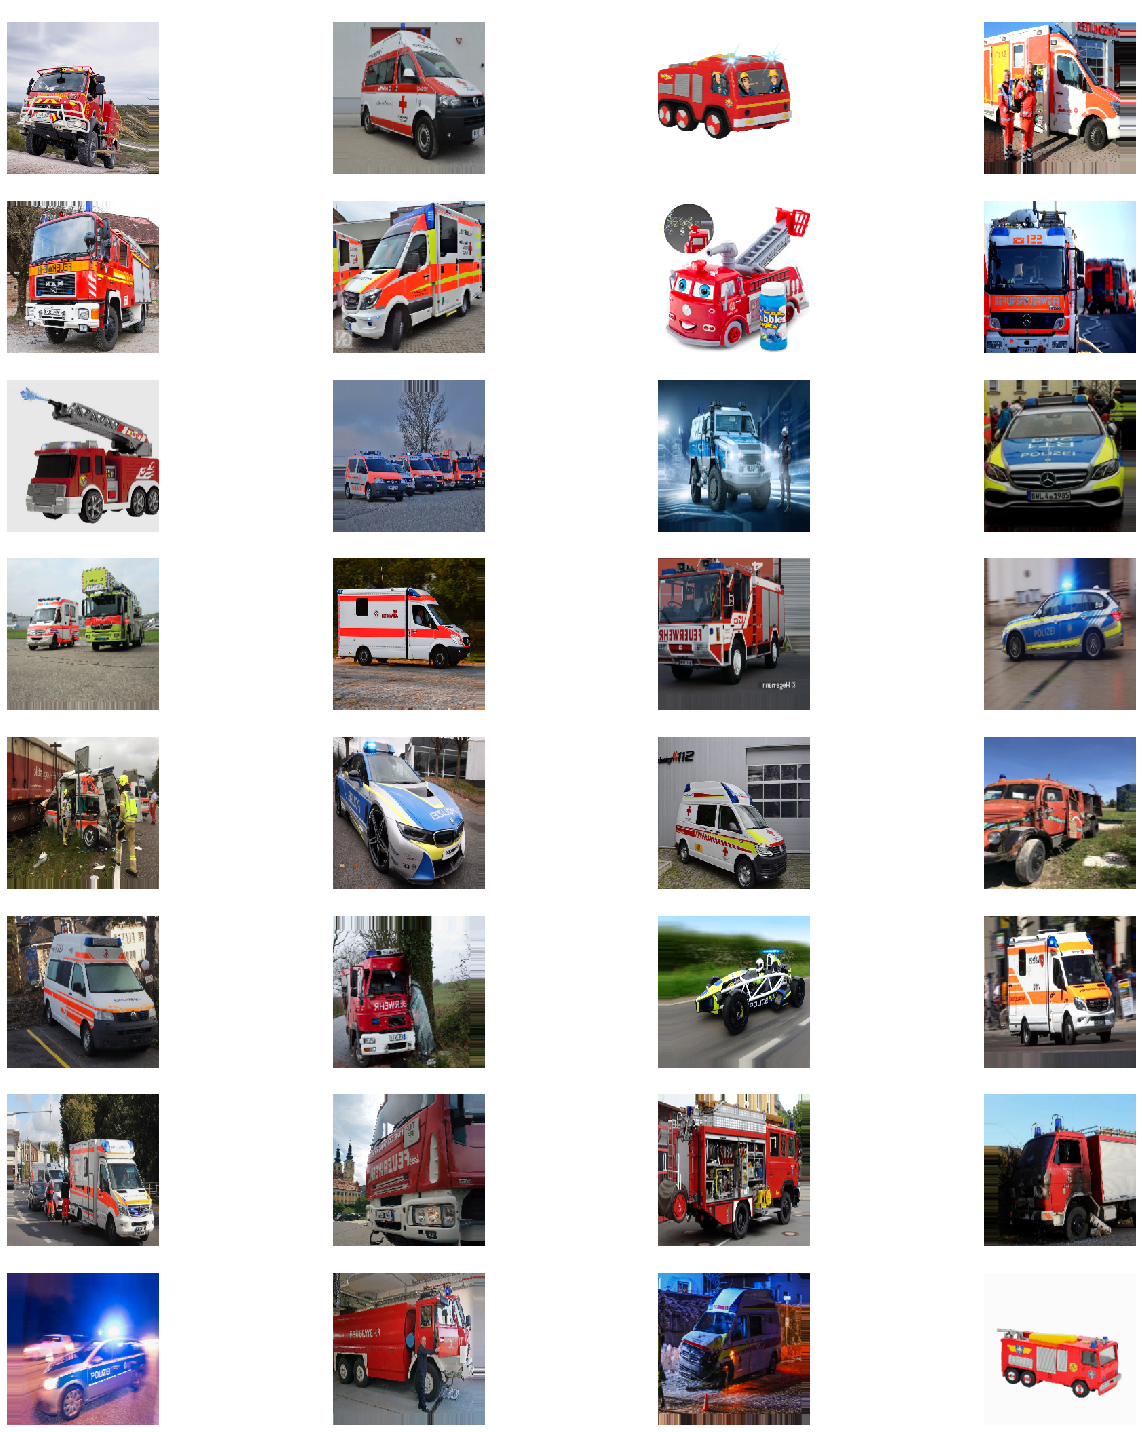

In [6]:
sample_training_images, labels = next(train_generator)
class_label = {v:k for k,v in train_generator.class_indices.items()}
fig, axes = plt.subplots(8, 4, figsize=(20,20))
axes = axes.flatten()
for img, label, ax in zip(sample_training_images, labels, axes):
    ax.set_title(class_label[np.argmax(label)])
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Create model

In [7]:
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(8, 3, padding='same', activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH ,3)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, 'relu'),
    tf.keras.layers.Dense(train_generator.num_classes, 'softmax')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 8)       224       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 112, 112, 8)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 112, 112, 16)      1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 56, 56, 16)        0         
_________________________________________________________________
flatten (Flatten)            (None, 50176)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               6422656   
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [8]:
model.layers

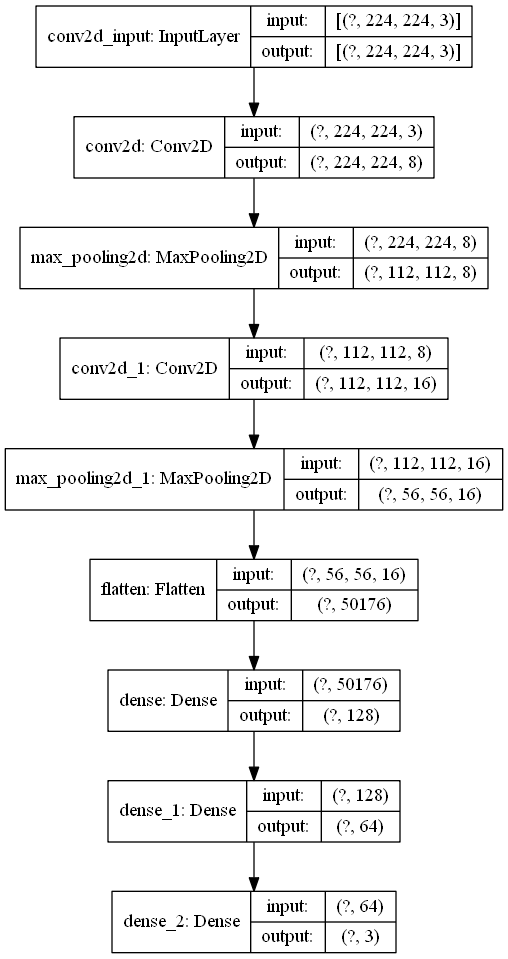

In [9]:
tf.keras.utils.plot_model(model, show_shapes=True)

In [10]:
hidden1 = model.layers[6]
hidden1.name

'dense_1'

In [11]:
model.get_layer(hidden1.name) is hidden1

True

In [12]:
weights, biases = hidden1.get_weights()

In [13]:
weights

array([[-0.11051068, -0.09682724, -0.03265263, ..., -0.05012722,
        -0.09121754, -0.12796862],
       [ 0.05527155,  0.13715555, -0.10828575, ...,  0.03095134,
         0.14316432, -0.00838225],
       [-0.14759359, -0.10319049,  0.09906174, ...,  0.06476782,
        -0.16760106, -0.01050641],
       ...,
       [-0.13580157, -0.02968293, -0.04849939, ..., -0.09499726,
         0.00229384, -0.08455598],
       [ 0.04612248,  0.13252215, -0.09527029, ...,  0.06877363,
        -0.16572908,  0.03816566],
       [ 0.10050599, -0.11471753,  0.05179489, ...,  0.00205466,
         0.14215703,  0.08310352]], dtype=float32)

In [14]:
weights.shape

(128, 64)

In [15]:
biases

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [16]:
biases.shape

(64,)

In [17]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['categorical_accuracy', tf.keras.metrics.AUC(name="auc")])


In [18]:
history = model.fit_generator(
    skip_broken_images(train_generator),
    steps_per_epoch=train_generator.n / train_generator.batch_size,
    epochs=EPOCHS,
    validation_data=skip_broken_images(validation_generator),
    validation_steps=5,
    callbacks=[snapshot_callback, tensorboard_callback]
)



Epoch 1/20
6/6 [==========================>...] - ETA: 0s - loss: 2.8214 - categorical_accuracy: 0.3820 - auc: 0.5343
Epoch 00001: saving model to ./snapshots
Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 22s 3s/step - loss: 2.8594 - categorical_accuracy: 0.3905 - auc: 0.5290 - val_loss: 2.4839 - val_categorical_accuracy: 0.4079 - val_auc: 0.5835
Epoch 2/20
6/6 [==========================>...] - ETA: 0s - loss: 1.4042 - categorical_accuracy: 0.4157 - auc: 0.5879
Epoch 00002: saving model to ./snapshots
INFO:tensorflow:Assets written to: ./snapshots\assets
7/6 [================================] - 12s 2s/step - loss: 1.3733 - categorical_accuracy: 0.4000 - auc: 0.5820 - val_loss: 1.0360 - val_categorical_accuracy: 0.4539 - val_auc: 0.6567
Epoch 3/20
6/6 [==========================>...] - ETA: 0s - loss: 1.0556 - categorical_accuracy: 0.5000 - auc: 0.6291
Epoch

In [19]:
weights, biases = hidden1.get_weights()

In [20]:
weights

array([[-0.11128765, -0.10282512, -0.02550977, ..., -0.04284964,
        -0.09121754, -0.12337925],
       [ 0.04971271,  0.13715555, -0.1117628 , ...,  0.02777537,
         0.14316432, -0.01224177],
       [-0.14180666, -0.10916347,  0.10505601, ...,  0.07077003,
        -0.16760106, -0.01050641],
       ...,
       [-0.13580157, -0.03566442, -0.05447111, ..., -0.08899883,
         0.00229384, -0.08455598],
       [ 0.04056364,  0.13252215, -0.09852325, ...,  0.06583898,
        -0.16572908,  0.03458827],
       [ 0.09510599, -0.11471753,  0.05698664, ...,  0.00723058,
         0.14215703,  0.08829579]], dtype=float32)

In [21]:
biases

array([-5.68613876e-03,  8.75117444e-03, -1.94786885e-03,  0.00000000e+00,
       -4.18777065e-03,  1.31402481e-02,  0.00000000e+00,  1.94541388e-03,
       -2.80631194e-03,  4.65088710e-03, -8.80442001e-03, -4.20303177e-03,
        1.66570873e-03, -8.76226928e-03,  1.44394324e-03,  6.00295234e-03,
       -8.10075458e-03, -2.14860402e-03, -2.63033807e-03, -2.44689779e-03,
        2.53914949e-03, -7.64682190e-03,  3.26773338e-03,  2.35363725e-03,
       -1.45191327e-03, -9.51537490e-03,  9.70989000e-03, -6.05418812e-03,
       -1.66172395e-04, -1.13568865e-02,  2.91784934e-04, -7.08560180e-03,
       -6.00446155e-03,  6.54071430e-03, -4.89811832e-03, -6.00511255e-03,
       -2.85107963e-05, -1.57880504e-02, -4.29177331e-03,  2.88215140e-03,
        8.43701791e-03, -3.23604792e-03, -6.00398704e-03, -1.29919767e-03,
        8.28550942e-03, -4.90048854e-03, -7.70470314e-03,  3.35527002e-03,
       -6.57307822e-03, -4.24566027e-03,  4.35626227e-03,  1.51143619e-03,
       -6.67323172e-03, -

# Plot confusion matrix & ROC

In [22]:
from sklearn.metrics import roc_curve, auc
from itertools import cycle
# Plot a confusion matrix.
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=45)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

def plot_roc(pred, compare):
    line_width = 2
    number_classes = 3
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for class_num in range(number_classes):
        comp_temp = []
        pred_temp = []
        for idx in range(len(compare)):
            if compare[idx] == class_num:
                comp_temp.append(1)
            else:
                comp_temp.append(0)
            if pred[idx] == class_num:
                pred_temp.append(1)
            else:
                pred_temp.append(0)   
        fpr[class_num], tpr[class_num], _ = roc_curve(comp_temp, pred_temp)
        roc_auc[class_num] = auc(fpr[class_num], tpr[class_num])
    
    colors = cycle(['darkorange', 'cornflowerblue', 'red'])
    for i, color in zip(range(number_classes), colors):
        plt.plot(fpr[i], tpr[i], color=color, lw=line_width,
                label='ROC curve of class {0} (area = {1:0.2f})'
                ''.format(class_label[i], roc_auc[i]))
    plt.plot([0, 1], [0, 1], 'k--', lw=line_width)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC One vs. all multi-class')
    plt.legend(loc="lower right")
    plt.show()

# Predictions

In [23]:
sample_test_images, labels_test = next(test_generator)
print(np.argmax(labels, axis=1))

[0 2 0 2 0 2 0 0 0 2 1 1 2 2 0 1 2 1 2 0 2 0 1 2 2 0 0 0 1 0 2 0]


In [24]:
def make_predictions(model, images, labels): 
    pred = model.predict(images )
    pred = np.argmax(pred,axis=1)
    compare = np.argmax(labels, axis=1)
    return pred, compare

In [25]:
pred, compare = make_predictions(model, sample_test_images, labels_test)
print(pred)
print(compare)

[0 0 2 2 0 2 0 1 1 0 0 0 1 1 1 2 1 0 0 1 0 0 0 1 1 1 1 1 2 0 0 1]
[0 0 2 2 0 1 0 1 1 0 0 0 1 1 1 2 1 0 2 1 0 2 0 1 1 1 1 1 2 0 0 1]


# Metric: Accuracy

In [26]:
from sklearn import metrics

score = metrics.accuracy_score(compare, pred)
print("Accuracy score: {}".format(score))



Accuracy score: 0.90625


# Metric: Accuracy

In [27]:
def plot_history(history): 
    acc = history.history['categorical_accuracy']
    val_acc = history.history['val_categorical_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(EPOCHS)

    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

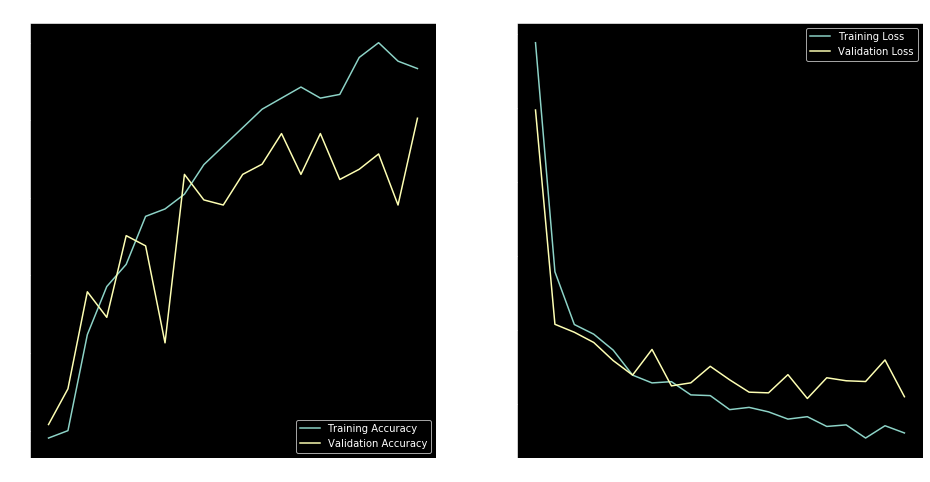

In [28]:
plot_history(history)


# Metric: AUC

In [29]:
def plot_auc(history): 
    auc = history.history['auc']
    val_auc = history.history['val_auc']
    epochs_range = range(EPOCHS)
    plt.figure(figsize=(16, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, auc, label='AUC')
    plt.plot(epochs_range, val_auc, label='Validation AUC')
    plt.legend(loc='lower right')
    plt.title('Training and Validation AUC')
    plt.show() 

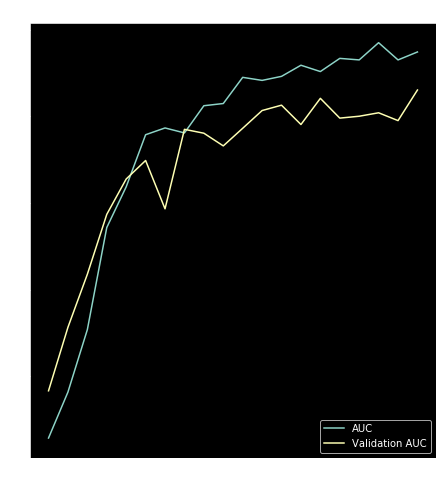

In [30]:
plot_auc(history) 


# Metric: Confusion Matrix 

In [31]:
from sklearn.metrics import confusion_matrix
def plot_metric_confusion_matrix(compare, pred):
    # Compute confusion matrix
    class_labels = {v:k for k,v in test_generator.class_indices.items()}
    cm = confusion_matrix(compare, pred)
    np.set_printoptions(precision=2)
    print('Confusion matrix, without normalization')
    print(cm)
    plt.figure()
    plot_confusion_matrix(cm, class_label)

    cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print('Normalized confusion matrix')
    print(cm_normalized)
    plt.figure()
    plot_confusion_matrix(cm_normalized, class_labels, title='Normalized confusion matrix')

    plt.show()

Confusion matrix, without normalization
[[12  0  0]
 [ 0 13  1]
 [ 2  0  4]]
Normalized confusion matrix
[[1.   0.   0.  ]
 [0.   0.93 0.07]
 [0.33 0.   0.67]]


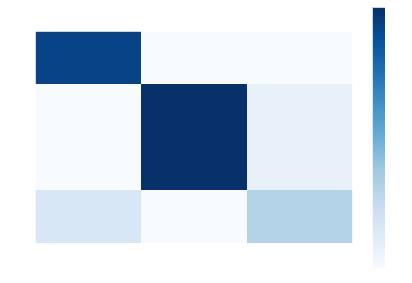

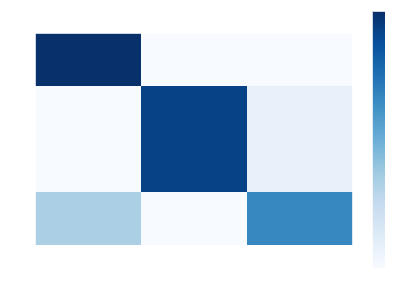

In [32]:
plot_metric_confusion_matrix(compare, pred)

# Metric: ROC

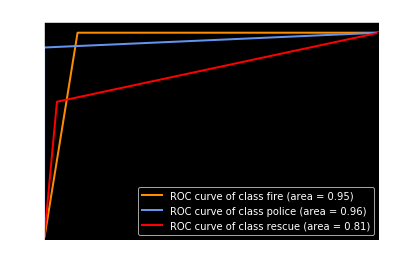

In [33]:
plot_roc(pred,compare)

# Testing predictions

In [34]:
def testing_predictions(model): 
    sample_training_images, labels = next(test_generator)
    class_label = {v:k for k,v in train_generator.class_indices.items()}
    fig, axes = plt.subplots(8, 4, figsize=(20,20))
    axes = axes.flatten()
    for img, ax in zip(sample_training_images, axes):
        img2 = np.expand_dims(img, axis=0)
        result = model.predict_classes(img2)
        ax.set_title(class_label[result[0]])
        ax.imshow(img)
        ax.axis('off')
    plt.tight_layout()

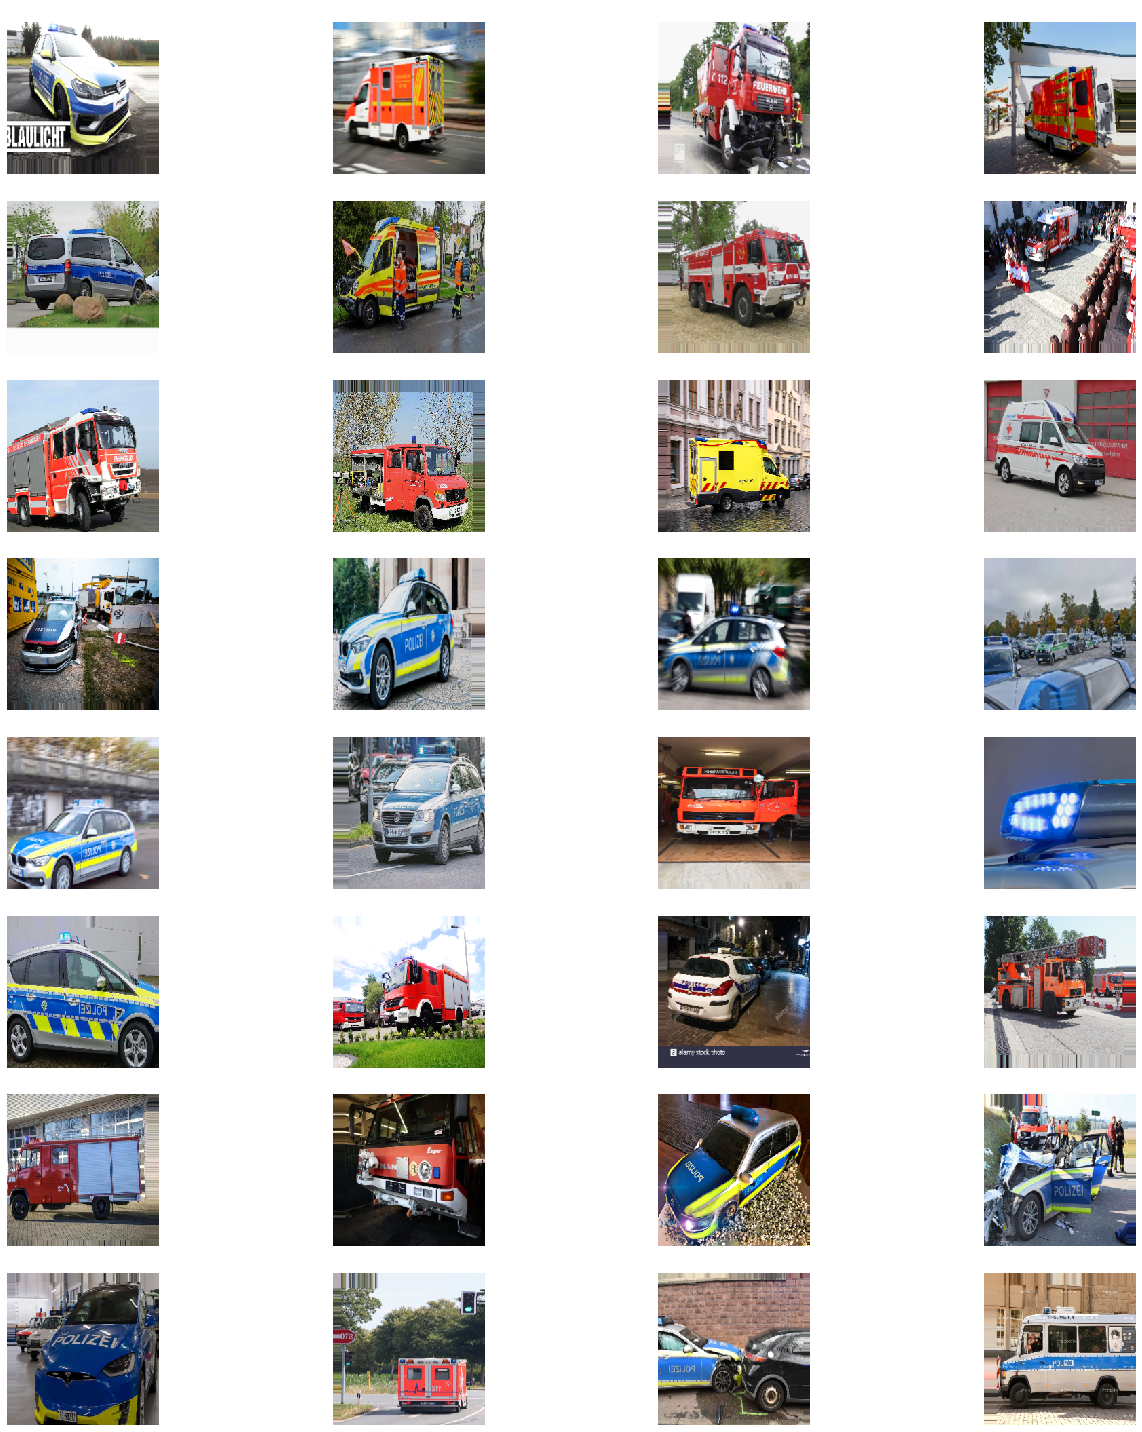

In [35]:
testing_predictions(model)


# Save model

In [36]:
model.save('cars.h5')

| batch_size | accuracy | acc_fire | acc_police | acc_rescue |
| ---------- | -------- | -------- | ---------- | ---------- |
| 32         | 0.906    | 0.92     | 0.94       | 0.71       |
| 16         | 0.781    | 0.93     | 0.91       | 0.75       |
| 8          | 0.75     | 0.74     | 0.96       | 0.75       |